In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import yfinance as yf
import warnings

In [2]:
# suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# SET CONSTANTS
INITIAL_INVESTMENT = 100
TICKERS = [
    'COST', 'AC.TO', 'META', 'NVDA', 'QBTS', 'T', 'JPM', 'BB', 'SNAP', 'SHOP.TO',
    'COKE', 'PEP', 'KO', 'MCD', 'SBUX', 'BA', 'YUM', 'MNST', 'WMT', 'BABA',
    'AMZN', 'AAPL', 'GOOGL', 'MSFT', 'TSLA', 'NFLX', 'DIS', 'SPY', 'AVGO', 'LLY',
    'XOM', 'CVX', 'COP', 'BP', 'NKE', 'MMM', 'VLO', 'PSX', 'MRO', 'OXY',
    'CCL', 'RCL', 'NCLH', 'AMC', 'BBY', 'F', 'GM', 'V', 'PG', 'CRM',
    'HON', 'QCOM', 'FIX', 'DUOL', 'GS', 'HD', 'AXP', 'VZ', 'IBM', 'CAT',
    
]

# test on the last 30 days
TEST_END_DATE = '2024-06-14'
TEST_START_DATE = '2024-04-14'

TRAIN_END_DATE = '2024-04-13'
TRAIN_START_DATE = '2021-01-01'


In [4]:
# download data
train_data, test_data = {}, {}

for ticker in TICKERS:
    df1 = yf.download(ticker, start=TRAIN_START_DATE, end=TRAIN_END_DATE, interval='1d').dropna()
    df2 = yf.download(ticker, start=TEST_START_DATE, end=TEST_END_DATE, interval='1d').dropna()
    
    # drop columns we dont need
    df1.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
    df2.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
    
    # rename columns
    df1.rename(columns={'Adj Close': 'price'}, inplace=True)
    df2.rename(columns={'Adj Close': 'price'}, inplace=True)
    
    # set index as datetime
    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)
    
    # set frequency as Weeks
    df1 = df1.asfreq('B')
    df2 = df2.asfreq('B')
    
    train_data[ticker] = df1.copy().dropna()
    test_data[ticker] = df2.copy().dropna()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

### 1. Use back-testing to select stocks that are 'good' for arima models

In [5]:
SETS = 50

results = {ticker: {} for ticker in TICKERS}

for ticker in TICKERS:
    print(f'Fitting models for {ticker}...')
    
    fit = np.array([])
    interval_75 = np.array([])
    interval_95 = np.array([])
    error = np.array([])
    
    for i in range(SETS):
        # splice data to get training data
        data = train_data[ticker]['price'].iloc[i:-(SETS-i)]

        ar_model = auto_arima(
            data, 
            start_p=0, 
            start_d=0,
            start_q=0, 
            max_p=10,
            max_d=5,
            max_q=10,
            seasonal=False, 
            trace=False
        )
        
        # if an ARIMA model could be fit...
        if ar_model.order[0] != 0 and ar_model.order[1] != 0:
            fit = np.append(fit, 1)
            
            # forecast next days price
            model_fit = ARIMA(data, order=ar_model.order).fit()
            forecast = model_fit.get_forecast()
            conf_int_75 = forecast.conf_int(alpha=0.25)
            conf_int_95 = forecast.conf_int(alpha=0.05)
            next_price = train_data[ticker]['price'].iloc[-(SETS-i)]
            
            # check if the actual price is within the 75% confidence interval of forecast
            if next_price >= conf_int_75.iloc[0, 0] and next_price <= conf_int_75.iloc[0, 1]:
                interval_75 = np.append(interval_75, 1)
            else:
                interval_75 = np.append(interval_75, 0)
                
            # check if the actual price is within the 95% confidence interval of forecast
            if next_price >= conf_int_95.iloc[0, 0] and next_price <= conf_int_95.iloc[0, 1]:
                interval_95 = np.append(interval_95, 1)
            else:
                interval_95 = np.append(interval_95, 0)
            
            # calculate mean absolute error of forecast
            abs_pct_err = np.abs((next_price - forecast.predicted_mean.iloc[0])/next_price)
            error = np.append(error, abs_pct_err)
        
        else:
            fit = np.append(fit, 0)

    # percent of testing sets that could be fit with ARIMA
    results[ticker]['percent_fit'] = np.mean(fit)
    # percent of actual prices that were in the 95% confidence interval of forecast
    results[ticker]['95% confidence interval'] = np.mean(interval_95)
    # percent of actual prices that were in the 75% confidence interval of forecast
    results[ticker]['75% confidence interval'] = np.mean(interval_75)
    # mean absolute error of forecasts to actual prices
    results[ticker]['mae'] = np.mean(error)
    
    print(f'Percent of ARIMA fits: {results[ticker]["percent_fit"]}')  
    print(f'% of actual price in 95% forecast confidence interval: {results[ticker]["95% confidence interval"]}')
    print(f'% of actual price in 75% forecast confidence interval: {results[ticker]["75% confidence interval"]}')
    print(f'Percent Mean Absolute Error of forecasts: {results[ticker]["mae"]} \n')

Fitting models for COST...
Percent of ARIMA fits: 0.0
% of actual price in 95% forecast confidence interval: nan
% of actual price in 75% forecast confidence interval: nan
Percent Mean Absolute Error of forecasts: nan 

Fitting models for AC.TO...
Percent of ARIMA fits: 0.0
% of actual price in 95% forecast confidence interval: nan
% of actual price in 75% forecast confidence interval: nan
Percent Mean Absolute Error of forecasts: nan 

Fitting models for META...
Percent of ARIMA fits: 0.8
% of actual price in 95% forecast confidence interval: 0.875
% of actual price in 75% forecast confidence interval: 0.6
Percent Mean Absolute Error of forecasts: 0.015637184692659713 

Fitting models for NVDA...
Percent of ARIMA fits: 0.54
% of actual price in 95% forecast confidence interval: 0.5185185185185185
% of actual price in 75% forecast confidence interval: 0.4074074074074074
Percent Mean Absolute Error of forecasts: 0.02500305621165175 

Fitting models for QBTS...
Percent of ARIMA fits: 0.0

In [6]:
results

{'COST': {'percent_fit': 0.0,
  '95% confidence interval': nan,
  '75% confidence interval': nan,
  'mae': nan},
 'AC.TO': {'percent_fit': 0.0,
  '95% confidence interval': nan,
  '75% confidence interval': nan,
  'mae': nan},
 'META': {'percent_fit': 0.8,
  '95% confidence interval': 0.875,
  '75% confidence interval': 0.6,
  'mae': 0.015637184692659713},
 'NVDA': {'percent_fit': 0.54,
  '95% confidence interval': 0.5185185185185185,
  '75% confidence interval': 0.4074074074074074,
  'mae': 0.02500305621165175},
 'QBTS': {'percent_fit': 0.0,
  '95% confidence interval': nan,
  '75% confidence interval': nan,
  'mae': nan},
 'T': {'percent_fit': 0.0,
  '95% confidence interval': nan,
  '75% confidence interval': nan,
  'mae': nan},
 'JPM': {'percent_fit': 0.08,
  '95% confidence interval': 1.0,
  '75% confidence interval': 1.0,
  'mae': 0.005867867685072571},
 'BB': {'percent_fit': 0.4,
  '95% confidence interval': 1.0,
  '75% confidence interval': 1.0,
  'mae': 0.024774526189347574},


In [51]:
# criteria to determine if a stock is a good fit for ARIMA
pct_fits = 0.01
pct_95 = 0.5

candidate_tickers = {ticker: results[ticker] for ticker in results.keys() if results[ticker]['percent_fit'] > pct_fits and results[ticker]['75% confidence interval'] > pct_75}

In [52]:
candidate_tickers

{'META': {'percent_fit': 0.8,
  '95% confidence interval': 0.875,
  '75% confidence interval': 0.6,
  'mae': 0.015637184692659713},
 'JPM': {'percent_fit': 0.08,
  '95% confidence interval': 1.0,
  '75% confidence interval': 1.0,
  'mae': 0.005867867685072571},
 'BB': {'percent_fit': 0.4,
  '95% confidence interval': 1.0,
  '75% confidence interval': 1.0,
  'mae': 0.024774526189347574},
 'MNST': {'percent_fit': 0.44,
  '95% confidence interval': 0.9545454545454546,
  '75% confidence interval': 0.7727272727272727,
  'mae': 0.009225579740375515},
 'BABA': {'percent_fit': 0.84,
  '95% confidence interval': 1.0,
  '75% confidence interval': 1.0,
  'mae': 0.016043007714953393},
 'MSFT': {'percent_fit': 0.38,
  '95% confidence interval': 1.0,
  '75% confidence interval': 0.8947368421052632,
  'mae': 0.007091617309690319},
 'NFLX': {'percent_fit': 0.76,
  '95% confidence interval': 1.0,
  '75% confidence interval': 0.7894736842105263,
  'mae': 0.01263747907645366},
 'AVGO': {'percent_fit': 0.

### Trade

In [53]:
# simulation plot function
def plot_simulation(data: pd.Series, transactions: dict, title: str, subtitles: list) -> None:
    fig, axs = plt.subplots(len(transactions), 1, figsize=(12, 3*len(transactions)))
    y_limits = [data.min(), data.max()]

    for i, (_, trans) in enumerate(transactions.items()):
        axs[i].plot(data)

        curr_val = trans[-1]['value'] if trans else INITIAL_INVESTMENT
        returns = (curr_val - INITIAL_INVESTMENT) / INITIAL_INVESTMENT
        text = (
            f'Strategy: {subtitles[i]}\n'
            f'Current Value: ${np.round(curr_val, 2)}, Returns: {np.round(returns*100, 2)}%'
        )
        axs[i].set_title(text)
        axs[i].grid()
        
        # vertical lines for transactions
        for n in range(0, len(trans)-1, 2):
            axs[i].axvline(trans[n]['date'], color='r' , linestyle='--')
            axs[i].axvline(trans[n+1]['date'], color='g' , linestyle='--')
            
            shade_color = 'green' if trans[n+1]['price'] > trans[n]['price'] else 'red'
            axs[i].fill_betweenx(y_limits, trans[n]['date'], trans[n+1]['date'], color=shade_color, alpha=0.1)
            
        # legend
        custom_labels = ['Price', 'Buy Transaction', 'Sell Transaction']
        axs[i].legend(custom_labels)
        
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()

In [54]:
def record_buy(buy_trans: list, date: datetime, price: float) -> list:
    prev_transaction = buy_trans[-1]['action'] if buy_trans else 'sell'
    
    if prev_transaction == 'sell':
        buy_trans.append({
            'date': date,
            'price': price,
            'action': 'buy',
            'value': buy_trans[-1]['value'] if buy_trans else INITIAL_INVESTMENT
        })

    return buy_trans

In [55]:
def record_sell(sell_trans: list, date: datetime, price: float) -> list:
    prev_transaction = sell_trans[-1]['action'] if sell_trans else None
    bought_today = sell_trans[-1]['date'] == date if sell_trans else False
    
    if prev_transaction == 'buy' and not bought_today:
        returns = (price - sell_trans[-1]['price']) / sell_trans[-1]['price']
        sell_trans.append({
            'date': date,
            'price': price,
            'action': 'sell',
            'value': (returns+1) * sell_trans[-1]['value']
        })
        
    return sell_trans

In [58]:
def simulate_transactions(ticker: str, train: pd.Series, test:pd.Series) -> pd.DataFrame:
    strategies = {
        'pos-ret': 'Buy when returns are positive',
        'th-0.001': 'Buy when returns are above 0.1%',
    }
    
    transactions = {strat: [] for strat in strategies.keys()}
    forecast_results = pd.DataFrame(
        columns=[
            'date',
            'actual_price',
            'forecast_price',
            'forecast_returns',
            '95_lower',
            '95_upper',
            '75_lower',
            '75_upper'
        ]
    )
    
    print (f'Fitting ARIMA model for {ticker}...')
    
    for i in range(len(test)):
        # update training data. Keep training data same length as when we initially fit the models
        data = pd.concat([train[SETS+i+1:], test.iloc[:i+1]])
        curr_price = data.iloc[-1]
        
        # find best ARIMA model
        model = auto_arima(
            data, 
            start_p=1, 
            start_d=1,
            start_q=1, 
            max_p=10,
            max_d=5,
            max_q=10,
            seasonal=False, 
            trace=False
        )
        
        # if an ARIMA model could be fit...
        if model.order[0] != 0 and model.order[1] != 0:
            # forecast confidence intervals, price, and returns
            forecast_model = ARIMA(data, order=model.order).fit().get_forecast()
            forecast = forecast_model.predicted_mean.iloc[0]
            forecast_returns = (forecast - data.iloc[-1]) / data.iloc[-1]
            conf_int_95 = forecast_model.conf_int(alpha=0.05)
            conf_int_75 = forecast_model.conf_int(alpha=0.25)
            
            if i < len(test)-1:
                forecast_results.loc[i] = [
                    test.index[i+1],
                    test.iloc[i+1],
                    forecast,
                    forecast_returns,
                    conf_int_95.iloc[0, 0],
                    conf_int_95.iloc[0, 1],
                    conf_int_75.iloc[0, 0],
                    conf_int_75.iloc[0, 1]
                ]
            
            # buy conditions
            # strategy: Buy when returns are positive ('pos-ret')
            if forecast_returns > 0:
                transactions['pos-ret'] = record_buy(transactions['pos-ret'], data.index[-1], curr_price)
            # strategy: Buy when returns are above 0.1% ('th-0.001')
            if forecast_returns > 0.001:
                transactions['th-0.001'] = record_buy(transactions['th-0.001'], data.index[-1], curr_price)
                
        # sell day after buying
        for trans in transactions.values():
            record_sell(trans, data.index[-1], curr_price)
        
    print(f'Forecasted data for {len(forecast_results)}/{len(test)-1} days. \n')
    
    return {'forecast_results': forecast_results.set_index('date'), 'transactions': transactions}

In [59]:
forecasts = {}

for ticker in candidate_tickers.keys():
    forecasts[ticker] = simulate_transactions(ticker, train_data[ticker]['price'], test_data[ticker]['price'])

Fitting ARIMA model for META...
Forecasted data for 42/42 days. 

Fitting ARIMA model for JPM...
Forecasted data for 20/42 days. 

Fitting ARIMA model for BB...
Forecasted data for 0/42 days. 

Fitting ARIMA model for MNST...
Forecasted data for 23/42 days. 

Fitting ARIMA model for BABA...
Forecasted data for 0/42 days. 

Fitting ARIMA model for MSFT...
Forecasted data for 18/42 days. 

Fitting ARIMA model for NFLX...
Forecasted data for 42/42 days. 

Fitting ARIMA model for AVGO...
Forecasted data for 0/42 days. 

Fitting ARIMA model for RCL...
Forecasted data for 3/42 days. 

Fitting ARIMA model for AMC...
Forecasted data for 0/42 days. 

Fitting ARIMA model for V...
Forecasted data for 0/42 days. 

Fitting ARIMA model for DUOL...
Forecasted data for 5/42 days. 



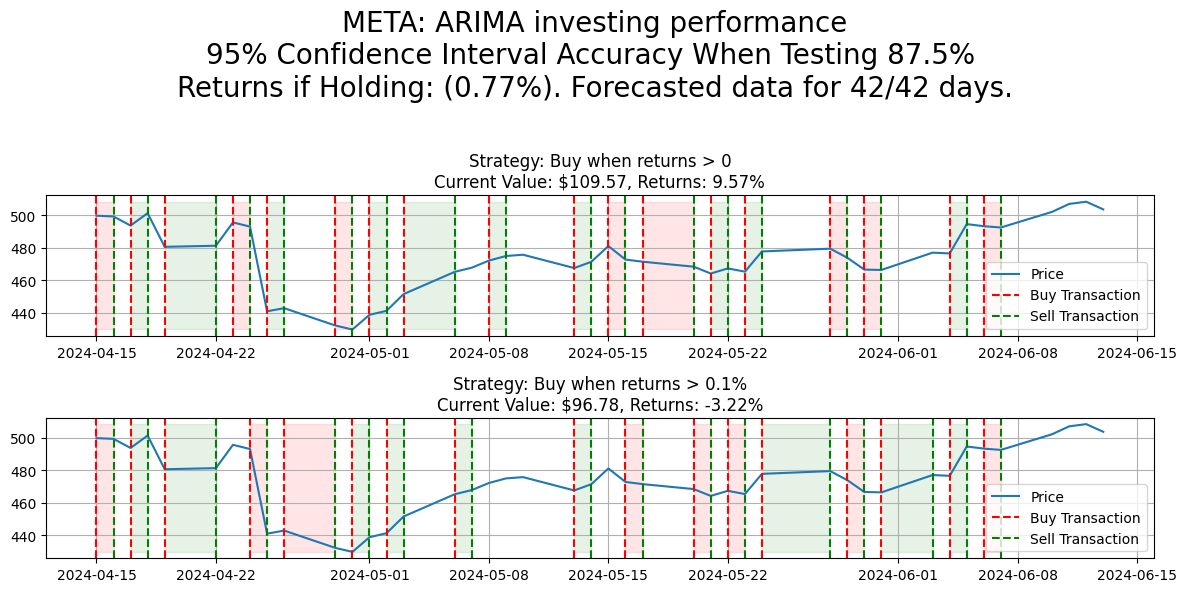

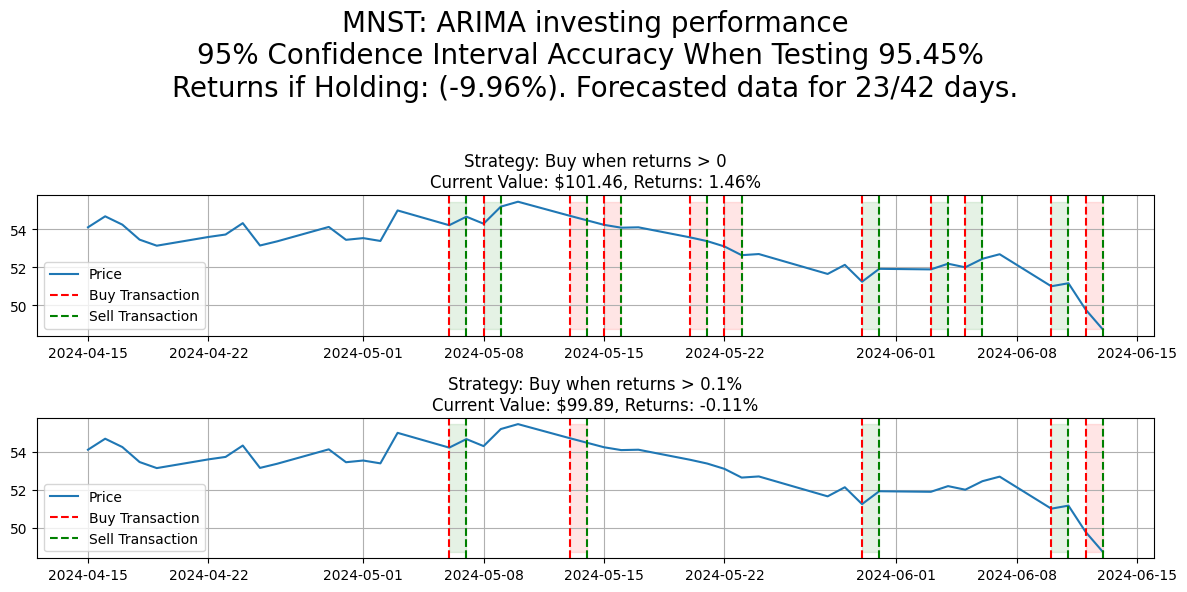

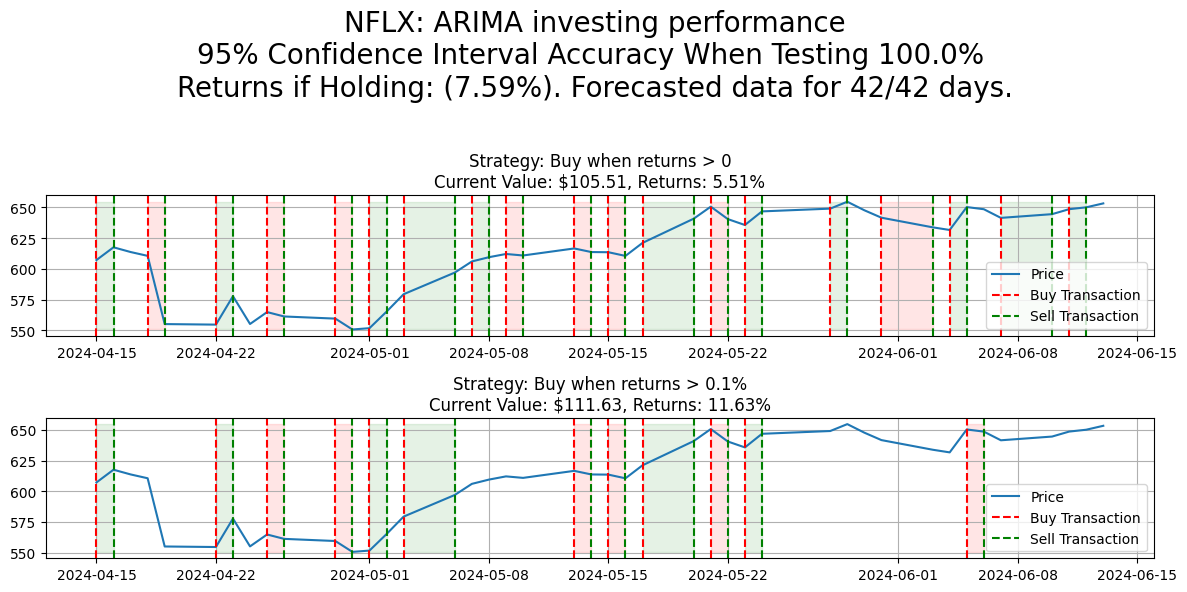

In [63]:
for ticker in candidate_tickers.keys():
    total_forecasts = len(forecasts[ticker]['forecast_results'])
    total_data = len(test_data[ticker]) - 1
    
    if total_forecasts >= 0.5*total_data:
        end_price = test_data[ticker]['price'].iloc[-1]
        start_price = test_data[ticker]['price'].iloc[0]
        hold_returns = np.round(100*(end_price - start_price)/start_price, 2)
        
        accuracy = np.round(100*candidate_tickers[ticker]['95% confidence interval'], 2)
        
        plot_simulation(
            test_data[ticker]['price'],
            forecasts[ticker]['transactions'],
            title=(
                f'{ticker}: ARIMA investing performance\n'
                f'95% Confidence Interval Accuracy When Testing {accuracy}% \n'
                f'Returns if Holding: ({hold_returns}%). Forecasted data for {total_forecasts}/{total_data} days.\n'
            ),
            subtitles=['Buy when returns > 0', 'Buy when returns > 0.1%']
        )